#### Data Setup

In [ ]:
import scanpy as sc
from google.colab import drive
drive.mount('/content/drive')

extract_dir = "/content/drive/MyDrive/STAT5243/Project 1/Data/"
adata = sc.read_h5ad(extract_dir+'cleaned_processed_frogtail.h5ad')

# Subset on the time point 0
adata = adata[adata.obs['DaysPostAmputation'] == 0]
adata.layers['counts'] = adata.X.copy()  # Raw counts layer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
<ipython-input-37-6faa5129b830>:10: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts'] = adata.X.copy()  # Raw counts layer


Interpretation:
This loads the dataset and subsets it to focus on Day 0, which is the baseline before tail amputation. You’re focusing on pre-regeneration data to find the Regenerative Organizing Cell (ROC) population.

i.e  “Data were preprocessed to focus on Day 0, prior to tail amputation, in order to identify potential regeneration-organizing cells in the skin tissue.”

#### Highly Variable Gene Selection & PCA Anlaysis

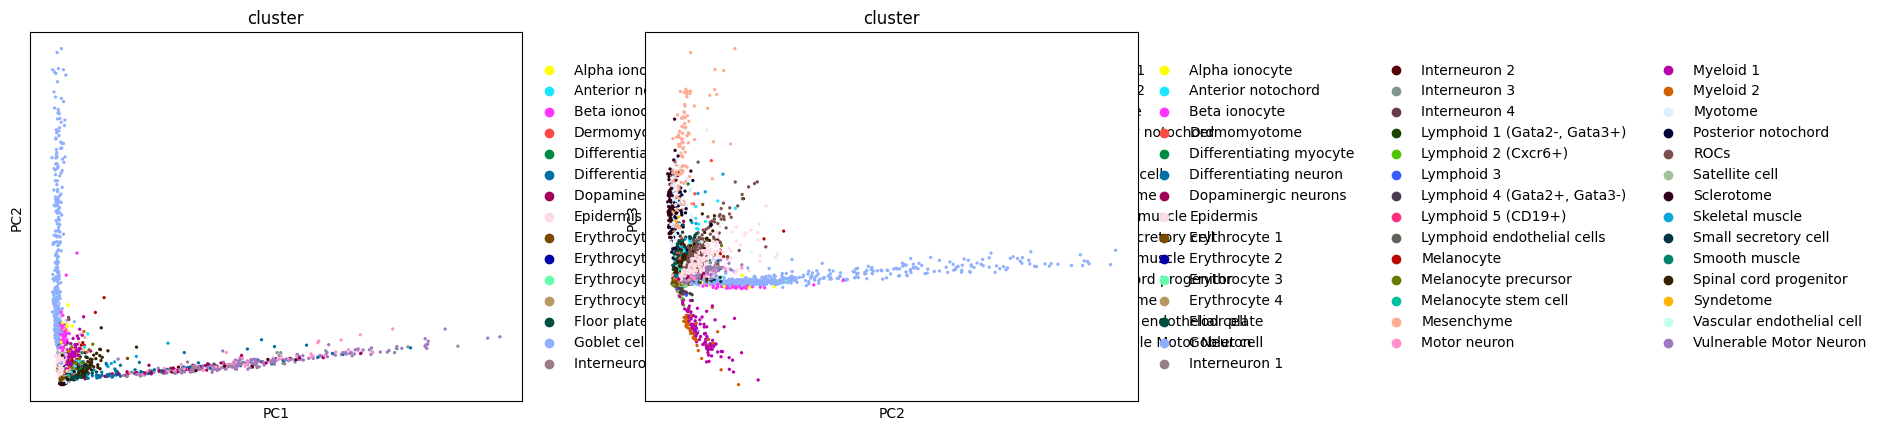

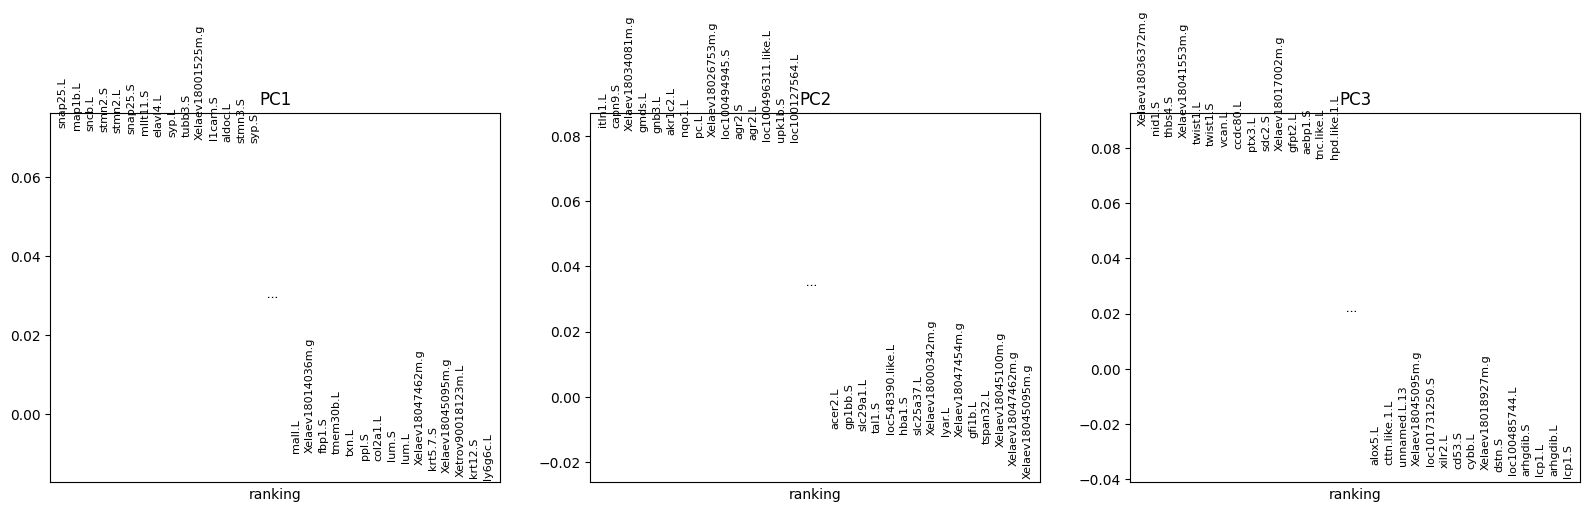

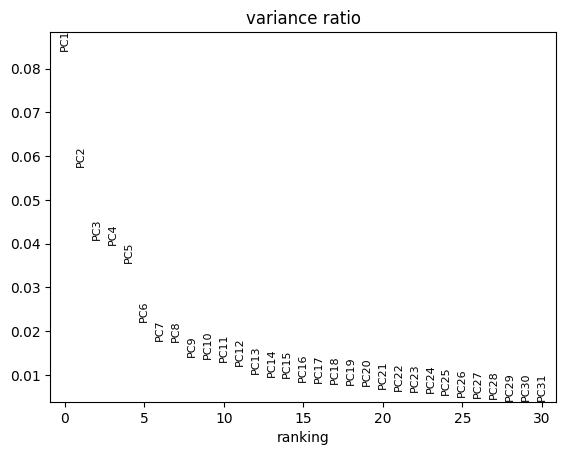

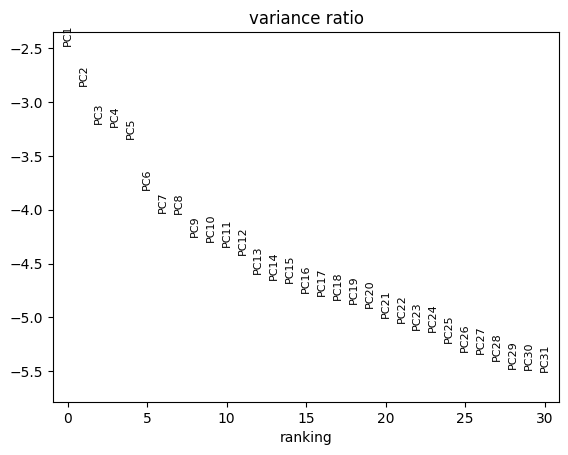

In [ ]:
# Log normalize the data and select 2000 highly variable genes
hvg_adata = sc.pp.log1p(adata, copy=True)
sc.pp.highly_variable_genes(hvg_adata, n_top_genes=2000)
sc.pp.scale(hvg_adata)

# PCA analysis
sc.tl.pca(hvg_adata)
sc.pl.pca_overview(hvg_adata, color='cluster', components=['1,2', '2,3'])
sc.pl.pca_variance_ratio(hvg_adata, log=True)

Interpretation:
PCA reduces the data's dimensionality to focus on the major sources of variance. The PCA plots show how the data clusters in the first two principal components, while the variance ratio plot shows the proportion of total variance explained by each component.

“Principal component analysis (PCA) was conducted on 2000 highly variable genes to reduce data dimensionality."

#### Clustering

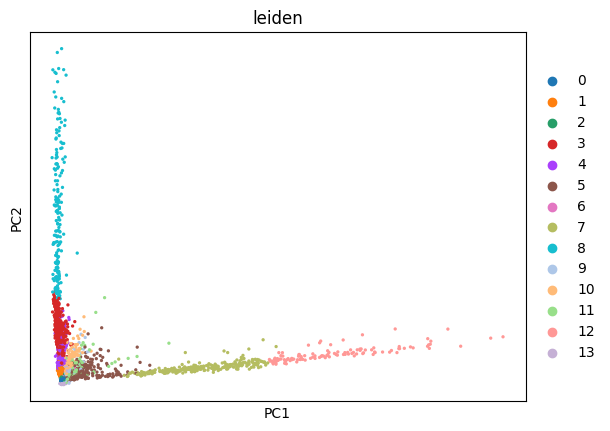

In [ ]:
# Create neighbors graph using PCA, then perform clustering using Leiden
sc.pp.neighbors(hvg_adata, n_pcs=7)
sc.tl.leiden(hvg_adata, resolution=0.5)

# Visualize the PCA plot colored by clusters
sc.pl.pca(hvg_adata, color=['leiden'])

Interpretation:
This step groups the cells into clusters based on their gene expression profiles. The PCA plot colored by Leiden clusters shows how cells are grouped, and the clusters are labeled.

#### Clustering Evalution (metrics)

In [ ]:
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Convert Leiden labels to integers for metric calculations
leiden_labels = hvg_adata.obs['leiden'].astype(int)

# Silhouette Score
silhouette = silhouette_score(hvg_adata.obsm['X_pca'], leiden_labels)
print(f'Silhouette Score: {silhouette}')

Silhouette Score: 0.14188484847545624


Interpretation:
Silhouette scores range from -1 to 1, with values closer to 1 indicating better-defined clusters. ARI compares the clustering with true labels (if available) and ranges from -1 to 1, with higher scores indicating better agreement.

Include in Results: “The clustering was evaluated using the Silhouette score (0.14). A high Silhouette score indicates well-separated clusters."

#### Marker Gene Selection

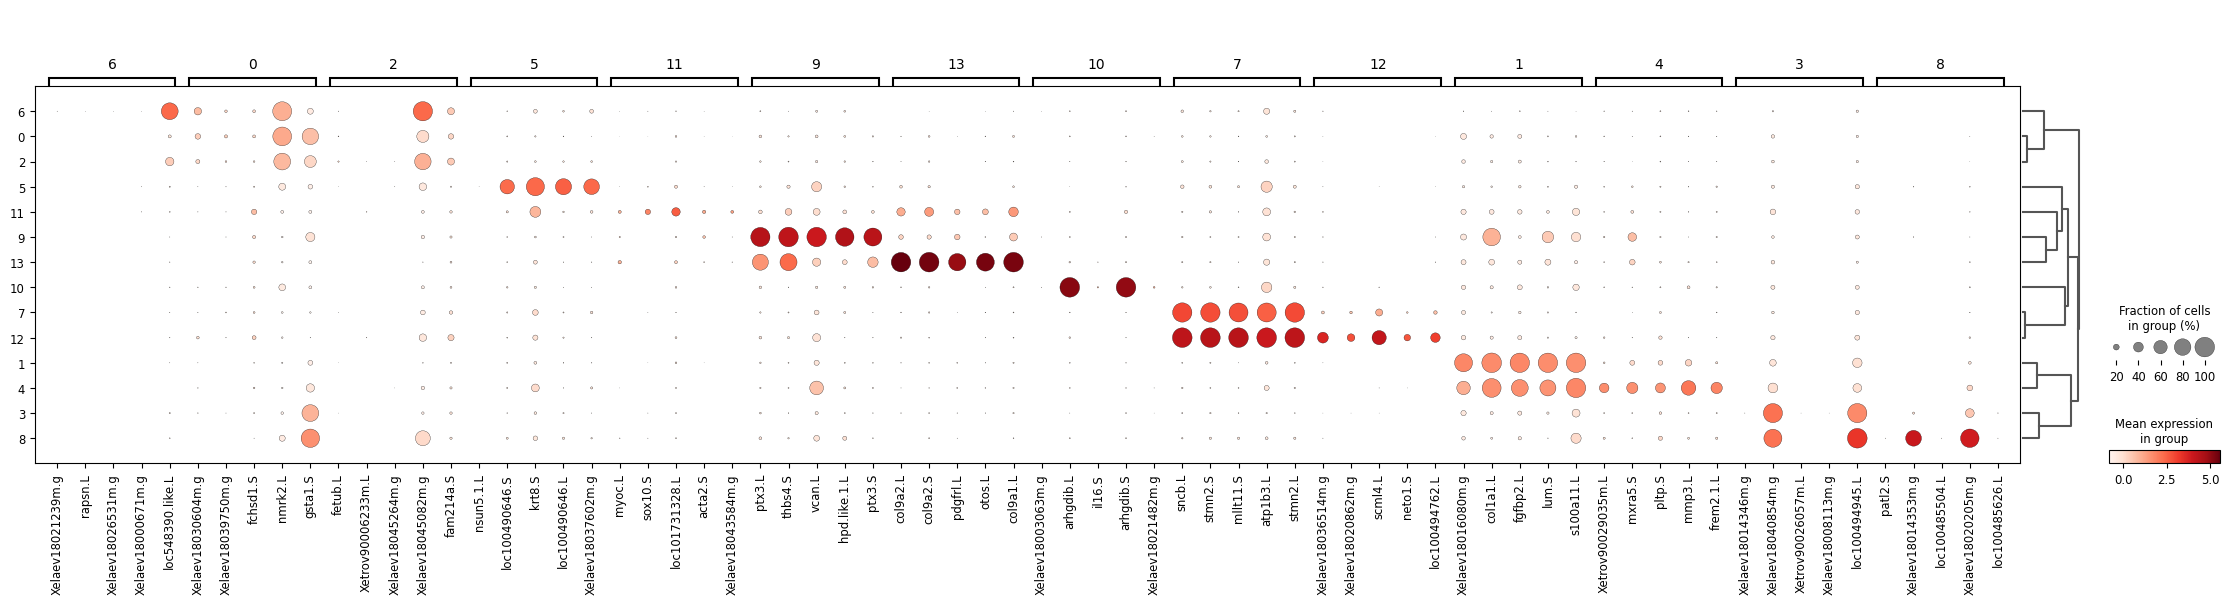

In [ ]:
# Use logistic regression for marker selection
sc.tl.rank_genes_groups(hvg_adata, groupby='leiden', method='logreg')
sc.pl.rank_genes_groups_dotplot(hvg_adata, n_genes=5)  # Visualize top 5 markers per cluster

Interpretation:
This step identifies genes that define each cluster, highlighting the ROC-specific genes. You’ll visualize the top marker genes per cluster using a dot plot.

“Logistic regression identified the top marker genes for each cluster, with a particular focus on genes associated with ROC. Figure above shows the top markers for each cluster.”